# Ice Surface Velocity 

In [1]:
# IMPORT REQUIRED MODULES [velocity_download environment]
import os
import csv
import json
import geopandas as gpd
import pandas as pd
import xarray as xr
from datetime import datetime
from shapely.geometry import box
from urllib.request import urlopen

## ITS LIVE (2018-2023)
The first block of this script will download all available 6-day and 12-day velocity pairs between 2018 and 2023 using the ITS LIVE Zarr Datacubes (https://its-live.jpl.nasa.gov/). Sequential identifiers are used to ensure that files with duplicate filenames are all saved.

Calculate the number of datacubes intersecting the specified study region.

In [50]:
# DEFINE THE OUTPUT DIRECTORY TO WHICH THE 6-DAY PAIRS SHOULD BE DOWNLOADED
output_dir = 'C:/Users/s2451953/Desktop/TEST/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# DEFINE THE STUDY REGION FOR THE 6-DAY PAIRS (JAKOBSHAVN ISBRAE)
bounds = -190000, -2290000, -145000, -2260000 # xmin, ymin, xmax, ymax
aoi_3413 = gpd.GeoDataFrame(geometry=[box(*(bounds))], crs=3413)

# SEARCH AND PRINT THE NUMBER OF DATACUBES INTERSECTING THE STUDY REGION
url = 'https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json'
response = urlopen(url)
data_json = json.loads(response.read())
df = pd.read_json('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')
gdf = gpd.GeoDataFrame.from_features(df["features"])
gdf = gdf[gdf['epsg']==3413]
gdf = gdf.set_crs(4326).to_crs(3413)
gdf_intsct = gdf[gdf.intersects(aoi_3413.geometry.values[0])]
number_of_datacubes = len(gdf_intsct)
print('The number of datacubes intersecting the study region is:', number_of_datacubes)

The number of datacubes intersecting the study region is: 1


Prepare the files to be downloaded, specifying only 6-day and 12-day pairs should be included. 

In [51]:
# PREPARE DATA STRUCTURES TO PROCESS THE ZARR FILES
url_zarr_list = gdf_intsct.zarr_url.values
xds_list = []
fn_list = []
filename_counts = {}

for url_zarr in url_zarr_list:
    filename = os.path.basename(url_zarr).split('.')[0]
    fn_list.append(filename)
    print(f'Preparing dataset from tile {filename}')
    xds = xr.open_zarr(url_zarr) # Open the ZARR file in xarray
    if filename in filename_counts: # Modify the filename to include a sequential identifier
        filename_counts[filename] += 1
        identifier = f'T{filename_counts[filename]}' # Append 'T' and the count
    else:
        filename_counts[filename] = 1
        identifier = ''  # No identifier added if it is the first occurrence of the filename
    filename = f'{filename}{identifier}'
    xds = xds[['satellite_img1','satellite_img2','acquisition_date_img1','acquisition_date_img2', 'date_dt','v']]
    xds = xds.rio.write_crs('epsg:3413')
    xds = xds.rio.clip(aoi_3413.geometry) # Clip to the study region
    xds = xds.where(((xds.date_dt.dt.days == 6) | (xds.date_dt.dt.days == 12)).compute(), drop=True) # Include 6-day and 12-day Pairs
    xds = xds.where(((xds.satellite_img1 == '1A') | (xds.satellite_img1 == '1B')).compute(), drop=True)
    var_obj_list = ['satellite_img1', 'satellite_img2']
    for var in var_obj_list:
        xds[var] = xds[var].astype('str')
    xds = xds.chunk()
    xds_list.append(xds)
    print(f'Appending to list.')

Preparing dataset from tile ITS_LIVE_vel_EPSG3413_G0120_X-150000_Y-2250000
Appending to list.


Download the specified 6-day and 12-day tiff files to the defined output directory.

In [52]:
# LOOP THROUGH THE XDS_LIST AND FN_LIST TOGETHER
for xds, filename in zip(xds_list, fn_list):
    if not os.path.exists(f'{output_dir}/{filename}'):
        os.mkdir(f'{output_dir}/{filename}')
    print(f'Computing dataset {filename}. This may take a while...')
    with xds.compute() as xds:
        print(f'Computed dataset. Saving images...')
        filename_counts = {}
        for _, x in xds.groupby('mid_date'):
            outname = f'{x.acquisition_date_img1.dt.date.values[0]}_{x.acquisition_date_img2.dt.date.values[0]}_S{x.satellite_img1.values[0]}_S{x.satellite_img2.values[0]}'
            if outname in filename_counts:
                filename_counts[outname] += 1
                identifier = f'_T{filename_counts[outname]}'   
            else:
                filename_counts[outname] = 1
                identifier = '' 
            if identifier == '_T1':
                identifier = ''
            outfpath = f'{output_dir}/{filename}/{outname}{identifier}.tif'
            x.v.rio.to_raster(outfpath, compress='ZSTD', predictor=3, zlevel=1)
        print('Saved images.')

Computing dataset ITS_LIVE_vel_EPSG3413_G0120_X-150000_Y-2250000. This may take a while...
Computed dataset. Saving images...
Saved images.


Delete any tiff files within the output directory that don't fall within a specified date range (2018-2023).

In [53]:
# DELETE ANY FILES WHICH HAVE A 'MID-DATE' OUTSIDE OF THE DESIRED DATE RANGE
start_date = datetime(2018, 1, 1)
end_date = datetime(2022, 12, 31)
filtered_files = []
directory = 'C:/Users/s2451953/Desktop/TEST/ITS_LIVE_vel_EPSG3413_G0120_X-150000_Y-2250000'

for filename in os.listdir(directory):
    if filename.endswith('.tif'):
        parts = filename.split('_')
        file_end_date = datetime.strptime(parts[1], '%Y-%m-%d')
        if file_end_date < start_date or file_end_date > end_date:
            file_path = os.path.join(directory, filename)
            os.remove(file_path)
print("Deletion of tiff files outside the desired study period complete.")

Deletion of tiff files outside the desired study period complete.


The second section of this script will sample each 6-day and 12-day velocity tiff file at specified sampling points.

In [ ]:
# IMPORT REQUIRED MODULES [velocity_merge]
import os
import csv
from osgeo import gdal
import numpy as np
import datetime

Define the input and output file directories and provide the coordinates of the desired sampling locations. The code will sample velocity at these sampling locations and save the data to a CSV. For each data point, the filename of the tiff will be provided, with the start date, end date and mid date also shown. 

In [8]:
# DEFINE THE REGION AND PROVIDE THE FILEPATH TO THE GEOTIFFS
folder_path = 'C:/Users/s2451953/Desktop/TEST/ITS_LIVE_vel_EPSG3413_G0120_X-150000_Y-2250000'

# DEFINE THE OUTPUT CSV FILE LOCATION AND NAME
csv_file = 'C:/Users/s2451953/Desktop/TEST/ITS_LIVE_SAMPLED.csv'

# LIST THE X AND Y CO-ORDINATES AT WHICH VELOCITY SHOULD BE EXTRACTED
coordinates = [(-180091.9495, -2278118.175),  
    (-176595.9169, -2281533.351),
    (-171733.1094, -2280782.72),
    (-166897.6833, -2279795.733),
    (-161907.8652, -2279370.56),
    (-157584.877, -2279370.56),
    (-153231.406, -2279370.56),]

# CREATE A CSV THAT WILL SAMPLE VELOCITY FROM EACH POINT, PROVIDING DETAILS OF THE CORRESPONDING FILENAME, START DATE, END DATE AND MID DATE
csv_headers = ['Filename', 'start_date', 'end_date', 'mid_date']
for i, (x, y) in enumerate(coordinates, start=1):
    csv_headers.append(f'POINT_{i}_VELOCITY')  # Custom column headers for each point's velocity
with open(csv_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(csv_headers)
    for filename in os.listdir(folder_path):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            file_path = os.path.join(folder_path, filename)
            date_parts = filename.split('_')
            start_date = date_parts[0]
            end_date = date_parts[1]
            start_date_obj = datetime.datetime.strptime(start_date, "%Y-%m-%d")
            end_date_obj = datetime.datetime.strptime(end_date, "%Y-%m-%d")
            mid_date_obj = start_date_obj + (end_date_obj - start_date_obj) / 2
            mid_date = mid_date_obj.strftime("%Y/%m/%d")
            dataset = gdal.Open(file_path, gdal.GA_ReadOnly)
            if dataset is not None:
                values = [filename, start_date, end_date, mid_date]
                for x, y in coordinates:
                    geotransform = dataset.GetGeoTransform()
                    x_pixel = int((x - geotransform[0]) / geotransform[1])
                    y_pixel = int((y - geotransform[3]) / geotransform[5])
                    band = dataset.GetRasterBand(1)
                    value = band.ReadAsArray(x_pixel, y_pixel, 1, 1)[0][0]
                    if np.isnan(value):
                        value = ''
                    values.append(value)
                csv_writer.writerow(values)
                dataset = None

print(f"Data extracted and saved to '{csv_file}'.")

Data extracted and saved to 'C:/Users/s2451953/Desktop/TEST/ITS_LIVE_SAMPLED.csv'.


The third section of this script will use the outputted CSV file to plot a timeseries of velocity at the sampling points (2018-2023)

In [5]:
# IMPORT MODULES [velocity_download environment]
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np 
import datetime

In [10]:
# OPEN THE ITS_LIVE 6-DAY PAIRS CSV FILE 
ITS_LIVE_data = pd.read_csv(r'C:/Users/s2451953/Desktop/TEST/ITS_LIVE_SAMPLED.csv')

# DEFINE THE VELOCITY VARIABLE FOR EACH POINT
POINT1_VELOCITY = ITS_LIVE_data['POINT_1_VELOCITY']
POINT2_VELOCITY = ITS_LIVE_data['POINT_2_VELOCITY']
POINT3_VELOCITY = ITS_LIVE_data['POINT_3_VELOCITY']
POINT4_VELOCITY = ITS_LIVE_data['POINT_4_VELOCITY']
POINT5_VELOCITY = ITS_LIVE_data['POINT_5_VELOCITY']
POINT6_VELOCITY = ITS_LIVE_data['POINT_6_VELOCITY']
POINT7_VELOCITY = ITS_LIVE_data['POINT_7_VELOCITY']

# DEFINE THE MID-DATE VARIABLE
ITS_LIVE_data['mid_date'] = pd.to_datetime(ITS_LIVE_data['mid_date'], format='%Y/%m/%d')

# INPUT DESIRED X AXIS, Y AXIS, AND PLOT TITLES
xtitle = 'Date'
ytitle = 'Ice Velocity (km/yr)'
title = 'Jakobshavn Isbræ Ice Velocity (2018-2023)'

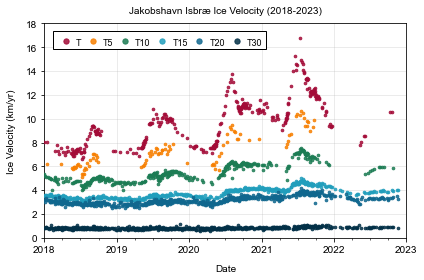

In [18]:
# CREATE A PLOT WITH GRID LINES
plt.rcParams["font.family"] = "Arial"
fig, ax = plt.subplots(figsize=(6, 4))
plt.title(title, pad=10, fontsize=10)
plt.grid(axis = 'x', alpha=0.3, zorder=0)
plt.grid(axis = 'y', alpha=0.3, zorder=0)
plt.ylabel(ytitle, labelpad=10, fontsize=10)
plt.xlabel(xtitle, labelpad=10)

# PLOT A SCATTER PLOT FOR EACH POINT
plt.scatter(ITS_LIVE_data['mid_date'], POINT1_VELOCITY/1000, color='#a30b37', s=7, marker='o', alpha=0.85, label='T', zorder=20)
plt.scatter(ITS_LIVE_data['mid_date'], POINT2_VELOCITY/1000, color='#f77f00', s=7, marker='o', alpha=0.85, label='T5', zorder=20)
plt.scatter(ITS_LIVE_data['mid_date'], POINT3_VELOCITY/1000, color='#1c7c54', s=7, marker='o', alpha=0.85, label='T10', zorder=20)
plt.scatter(ITS_LIVE_data['mid_date'], POINT4_VELOCITY/1000, color='#219ebc', s=7, marker='o', alpha=0.85, label='T15', zorder=20)
plt.scatter(ITS_LIVE_data['mid_date'], POINT5_VELOCITY/1000, color='#10678e', s=7, marker='o', alpha=0.85, label='T20', zorder=20)
plt.scatter(ITS_LIVE_data['mid_date'], POINT7_VELOCITY/1000, color='#023047', s=7, marker='o', alpha=0.85, label='T30', zorder=20)

# SET THE X AXIS TICK LIMITS
plt.ylim(0, 18)
plt.yticks(np.arange(0, 18+1, 2))

# DEFINE THE FORMATTING FOR THE X-TICKS
year_locator = mdates.YearLocator(base=1, month=1, day=1)
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
min_x_value = pd.to_datetime('2018-01-01', format='%Y-%m-%d')
max_x_value = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
plt.xlim(min_x_value, max_x_value)
three_month_intervals = mdates.MonthLocator(interval=3)
ax.xaxis.set_minor_locator(three_month_intervals)

# ADD A LEGEND WITH THREE COLUMNS, HORIZONTAL ARRANGEMENT, AND WHITE BACKGROUND
legend = plt.legend(loc='upper left', ncol=7, columnspacing=0.3, markerscale=2, frameon=True, framealpha=1, handletextpad=0.1, fontsize = 9, facecolor='white', borderaxespad = 0.9, borderpad=0.5, fancybox=False)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)
legend.set_zorder(20)
for text in legend.get_texts():
    text.set_va('center')

plt.tight_layout()